# Genetic algorithm: Eight Queens Problem
**Ricardo Antonio Gutiérrez Esparza \
Juan Marquina Cancino**

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt

In [2]:
rng = default_rng(6502729091)

## Genotype definition

Array of N elements. Each element represents the row where the piece sits in that column

## Objective function

In [3]:
def ObjectiveFunction(genotype):
    '''Returns the number of columns, rows and diagonals where an attack occurs
    '''
    N = len(genotype)
    rows = np.zeros(N, dtype=bool)
    diag = np.zeros(N * 2 - 1, dtype=bool)
    invDiag = np.zeros(N * 2 - 1, dtype=bool)
    ans = 0
    for c,r in enumerate(genotype):
        if rows[r] or diag[N - 1 + c - r] or invDiag[c + r]:
            ans += 1
        rows[r] = diag[N - 1 + c - r] = invDiag[c + r] = True
    
    return ans

In [4]:
def SolutionPermutation(N):
    '''Returns a random solution (not necessarily valid)
    '''
    return rng.permutation(N)

## Genetic Algorithm

In [5]:
def ParentSelectionRoulette(fitness):
    '''
        Input:  fitness -> Array of pop_size elements
        Output: Index of selected parent
    '''
    total = np.sum(fitness)
    roulette = np.cumsum(fitness / total)
    
    i = 0
    dart = rng.uniform()
    while roulette[i] < dart:
        i += 1
    return i

In [6]:
def ParentSelectionTournament(fitness, k=2):
    '''
        Input:  fitness -> Array of pop_size elements
                k -> size of tournament
        Output: Index of selected parent
    '''
    selection = rng.permutation(len(fitness))
    not_selection = selection[k:]
    raffle = fitness.copy()
    raffle[not_selection] = np.max(raffle) + 1
    return np.argmin(raffle)

In [7]:
def CrossoverSimplePermutation(parent1, parent2):
    cut = rng.integers(low=0, high=len(parent1))
    offspring = np.append(parent1[:cut], parent2[cut:])
    
    used = np.zeros(len(parent1), dtype=int)
    for x in offspring:
        used[x] += 1
    unused = []
    for i,x in enumerate(used):
        if x == 0:
            unused.append(i)
    unused = rng.permutation(unused)
    
    for i,x in enumerate(offspring):
        if used[x] > 1:
            used[x] -= 1
            offspring[i] = unused[-1]
            unused = unused[:-1]
            
    return offspring

In [8]:
def CrossoverPartiallyMapped(parent1, parent2):
    cut1 = rng.integers(low=0, high=len(parent1))
    cut2 = rng.integers(low=cut1, high=len(parent1))
    offspring = np.append(parent2[:cut1], parent1[cut1:cut2])
    offspring = np.append(offspring, parent2[cut2:])
    
    used = np.zeros(len(parent1), dtype=int)
    for x in offspring:
        used[x] += 1
    unused = []
    for x in parent2[cut1:cut2]:
        if used[x] == 0:
            unused.append(x)
    unused = unused[::-1]
    
    for i,x in enumerate(offspring[:cut1]):
        if used[x] > 1:
            used[x] -= 1
            offspring[i] = unused[-1]
            unused = unused[:-1]
            
    for i,x in enumerate(offspring[cut2:]):
        if used[x] > 1:
            used[x] -= 1
            offspring[i + cut2] = unused[-1]
            unused = unused[:-1]
    
    return offspring
    

In [9]:
def MutationSwap(genotype):
    g = rng.integers(low=0, high=len(genotype), size=2)
    
    genotype[g[0]], genotype[g[1]] = genotype[g[1]], genotype[g[0]]
    
    return genotype

In [10]:
def EQPCrossover(population, fitness, Pr):
    '''For this problem, we found that Tournament and Simple Permutation
       give the better results.
    '''
    new_population = []
    for i in range(len(population)): 
        if(rng.random() < Pr):
            parent1 = population[ParentSelectionTournament(fitness)]
            parent2 = population[ParentSelectionTournament(fitness)]
            new_population.append(CrossoverSimplePermutation(parent1, parent2))
        else:
            new_population.append(population[ParentSelectionTournament(fitness)])
    
    return new_population

In [11]:
def EQPMutation(population, Pm):
    new_population = []
    for genotype in population:
        new_population.append(MutationSwap(genotype) if rng.random() < Pm else genotype)
    return new_population

In [12]:
def EQPGeneticAlgorithm(boardSize=8, N=30, G=100, Pr=0.8, Pm=0.3):
    population = [SolutionPermutation(boardSize) for i in range(N)]
    fitness = np.array([ObjectiveFunction(genotype) for genotype in population])
    elite = population[np.argmin(fitness)].copy()
    elite_fx = np.min(fitness)
    
    current_g = 0
    while current_g < G:
        print(f'Generation #{current_g}: elite = {elite}, fitness = {elite_fx}')
        population = EQPCrossover(population, fitness, Pr)
        population = EQPMutation(population, Pm)
        fitness = np.array([ObjectiveFunction(genotype) for genotype in population])
        if(np.min(fitness) > elite_fx):
            max_idx = np.argmax(fitness)
            population[max_idx] = elite
            fitness[max_idx] = elite_fx
        else:
            elite = population[np.argmin(fitness)].copy()
            elite_fx = np.min(fitness)
            
        current_g += 1
    
    return elite, elite_fx
    

In [17]:
elite, elite_fx = EQPGeneticAlgorithm(8)
print(elite, elite_fx)

Generation #0: elite = [7 2 6 3 0 4 1 5], fitness = 1
Generation #1: elite = [7 2 6 3 0 4 1 5], fitness = 1
Generation #2: elite = [7 2 6 3 0 4 1 5], fitness = 1
Generation #3: elite = [6 0 5 3 1 7 4 2], fitness = 1
Generation #4: elite = [3 1 4 2 0 6 7 5], fitness = 1
Generation #5: elite = [3 1 4 2 0 6 7 5], fitness = 1
Generation #6: elite = [3 1 4 2 0 6 7 5], fitness = 1
Generation #7: elite = [4 6 0 5 1 3 7 2], fitness = 1
Generation #8: elite = [3 1 4 2 0 6 7 5], fitness = 1
Generation #9: elite = [3 6 0 7 1 4 2 5], fitness = 1
Generation #10: elite = [7 0 5 3 1 6 4 2], fitness = 1
Generation #11: elite = [3 6 0 5 4 1 7 2], fitness = 1
Generation #12: elite = [4 2 0 6 1 3 5 7], fitness = 1
Generation #13: elite = [7 0 5 3 1 6 4 2], fitness = 1
Generation #14: elite = [4 2 0 6 1 3 5 7], fitness = 1
Generation #15: elite = [4 2 0 6 1 3 5 7], fitness = 1
Generation #16: elite = [4 7 5 3 1 6 0 2], fitness = 1
Generation #17: elite = [4 7 5 3 1 6 0 2], fitness = 1
Generation #18: elit

## Plot solution

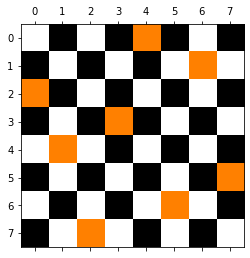

In [18]:
nrows, ncols = len(elite), len(elite)
image = np.zeros(nrows*ncols)

for i in range(nrows):
    begin = i * nrows + (1 if i % 2 else 0)
    image[begin:begin + nrows:2] = 1

for r,c in enumerate(elite):
    image[r * nrows + c] = 0.5

image = image.reshape((nrows, ncols))

plt.matshow(image, cmap='afmhot')
plt.show()